# Deep Q-Learning (DQN) for Syariah Investment

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque
import random

## Load Daily Data

In [2]:
# Load data
df = pd.read_csv("idx_shariah_daily.csv")

# Check Data
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,28-05-2025,226.01,227.56,227.92,225.89,13.33B,-0.08%
1,27-05-2025,226.19,226.24,226.52,225.33,12.23B,0.35%
2,26-05-2025,225.40,226.84,227.18,224.10,13.39B,-0.16%
3,23-05-2025,225.76,224.92,226.07,224.51,10.24B,0.65%
4,22-05-2025,224.32,224.16,225.47,223.85,12.58B,0.34%


In [3]:
# Rename columns for consistency
df.rename(columns={
    'Price': 'Close',
    'Vol.': 'Volume',
    'Change %': 'Change'
}, inplace=True)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Sort ascending
df = df.sort_values('Date').reset_index(drop=True)

# Clean Change (% → float)
df['Change'] = df['Change'].str.replace('%', '').astype(float)

# Convert Volume from string to number (e.g., 1.2B → 1_200_000_000)
def convert_volume(val):
    if isinstance(val, str):
        if 'B' in val:
            return float(val.replace('B', '')) * 1e9
        elif 'M' in val:
            return float(val.replace('M', '')) * 1e6
    return np.nan

df['Volume'] = df['Volume'].apply(convert_volume)

# Drop any rows with missing values
df.dropna(inplace=True)

# Check result
df.head()

,Date,Close,Open,High,Low,Volume,Change
0,2020-01-02,186.71,188.29,188.54,186.24,2.260000e+09,-0.54
1,2020-01-03,187.58,187.38,187.58,186.56,2.730000e+09,0.47
2,2020-01-06,185.35,186.99,187.20,185.31,2.520000e+09,-1.19
3,2020-01-07,185.65,185.53,186.17,184.65,2.410000e+09,0.16
4,2020-01-08,183.72,184.94,185.06,183.47,2.690000e+09,-1.04


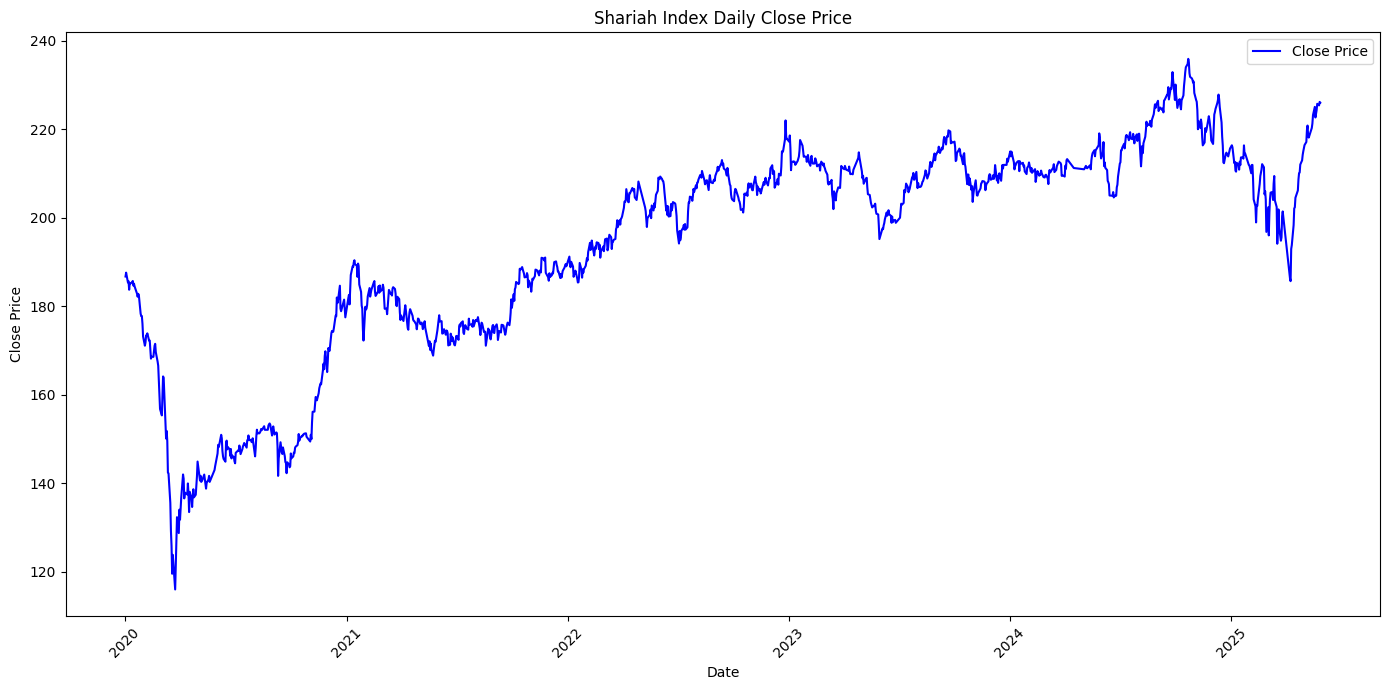

In [4]:
# Visualize the data by date
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Shariah Index Daily Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Preprocessing (windowing, normalize, split data)

In [5]:
# Normalisasi hanya kolom numerik (kecuali Date)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Check the normalized data
df.head()

,Date,Close,Open,High,Low,Volume,Change
0,2020-01-02,0.589814,0.604496,0.587489,0.598783,0.016045,0.420133
1,2020-01-03,0.597066,0.596891,0.579206,0.601450,0.027135,0.481013
2,2020-01-06,0.578478,0.593632,0.575928,0.591030,0.022180,0.380952
3,2020-01-07,0.580979,0.581432,0.567041,0.585529,0.019585,0.462327
4,2020-01-08,0.564891,0.576502,0.557463,0.575692,0.026192,0.389994


In [6]:
# Fungsi untuk membuat data window
def create_window_data(df, window_size=5):
    """
    Membuat data window untuk reinforcement learning.
    Args:
        df (pd.DataFrame): Dataframe yang berisi data pasar.
        window_size (int): Ukuran window untuk data.
    Returns:
        X (np.ndarray): Data window yang berisi fitur.
        y (np.ndarray): Target yang tidak digunakan dalam RL tapi tetap bisa dicatat.
    """
    # variabel untuk menyimpan data window
    X, y = [], []

    # Loop untuk membuat window data
    for i in range(window_size, len(df)):
        window = df[features].iloc[i-window_size:i].values  # shape: (5, 6)
        X.append(window)
        y.append(df['Close'].iloc[i])  # target tidak dipakai di RL tapi tetap bisa dicatat

    return np.array(X), np.array(y)

In [7]:
# variable untuk ukuran window
window_size = 5

# Membuat data window
X, _ = create_window_data(df, window_size)

# Cek bentuk data window
print(f"Shape of windowed data: {X.shape}")  # Expected shape: (n_samples, window_size, n_features)

Shape of windowed data: (1283, 5, 6)


In [8]:
# Split data into training and testing sets
# Use 70% for training and 30% for testing
split_idx = int(len(X) * 0.7)

# Split the data
X_train = X[:split_idx]
X_test = X[split_idx:]

# Check the flattened state shape
print(f"Flattened state shape: {X_train[0].flatten().shape}")

# Check the shapes of the training and testing data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Flattened state shape: (30,)
Training data shape: (898, 5, 6)
Testing data shape: (385, 5, 6)


## Define Environment for DQN

In [9]:
# Kelas untuk lingkungan trading DQN
class DQNTradingEnv:
    """
    Lingkungan untuk trading menggunakan DQN (Deep Q-Network).
    Lingkungan ini menyediakan state, action, dan reward untuk agen trading.
    """
    # Fungsi inisialisasi lingkungan
    def __init__(self, data, window_size=5):
        self.data = data
        self.window_size = window_size
        self.reset()

    # Fungsi reset untuk menginisialisasi ulang lingkungan
    def reset(self):
        self.current_step = self.window_size
        self.holding = False
        self.buy_price = 0
        self.total_profit = 0
        self.done = False
        self.history = []

        return self._get_state()

    # Fungsi untuk mendapatkan state saat ini
    def _get_state(self):
        """
        Mengambil state saat ini dari data.
        State terdiri dari window data yang berisi harga Open, High, Low, Close, Volume, dan Change.
        """
        return self.data[self.current_step].flatten()

    # Fungsi untuk melakukan langkah dalam lingkungan
    def step(self, action):
        """
        Actions:
        0 = Buy
        1 = Sell
        2 = Hold
        """
        reward = 0
        # Dapatkan harga penutupan dari hari terakhir dalam window
        window = self.data[self.current_step]
        close_price = float(window[-1][3])  # Hari ke-5, kolom Close

        if action == 0:  # Buy
            if not self.holding:
                self.holding = True
                self.buy_price = close_price
            else:
                reward = -1  # penalti karena sudah beli

        elif action == 1:  # Sell
            if self.holding:
                reward = float(close_price - self.buy_price)
                # reward = close_price - self.buy_price
                self.total_profit += reward
                self.holding = False
                self.buy_price = 0
            else:
                reward = -1  # penalti karena jual tanpa beli

        elif action == 2:  # Hold
            reward = 0

        # Lanjut ke step berikutnya
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True

        next_state = self._get_state() if not self.done else None

        return next_state, reward, self.done

In [10]:
# Inisialisasi lingkungan trading DQN
env = DQNTradingEnv(X_train, window_size=5)

# Cek ukuran window
print("\nEnvironment initialized.")
print("\nWindow size:", env.window_size)

# Cek bentuk state awal
state = env.reset()
print("Initial state shape:", state.shape)

# Simulasikan 10 langkah
for _ in range(10):
    action = np.random.choice([0, 1, 2])
    next_state, reward, done = env.step(action)

    # Print action, reward, next state, and other details
    reward_val = reward.item() if hasattr(reward, 'item') else reward
    
    print(f"\nAction: {action}, Reward: {reward_val:.2f}")
    print(f"Total profit: {env.total_profit:.2f}")
    print(f"Holding: {env.holding}, Buy Price: {env.buy_price:.2f}")
    print(f"Current step: {env.current_step}, Done: {done}")

    # Jika sudah selesai, keluar dari loop
    if done:
        print("Done!")
        break

    state = next_state


Environment initialized.

Window size: 5
Initial state shape: (30,)

Action: 0, Reward: 0.00
Total profit: 0.00
Holding: True, Buy Price: 0.57
Current step: 6, Done: False

Action: 1, Reward: 0.00
Total profit: 0.00
Holding: False, Buy Price: 0.00
Current step: 7, Done: False

Action: 0, Reward: 0.00
Total profit: 0.00
Holding: True, Buy Price: 0.57
Current step: 8, Done: False

Action: 2, Reward: 0.00
Total profit: 0.00
Holding: True, Buy Price: 0.57
Current step: 9, Done: False

Action: 0, Reward: -1.00
Total profit: 0.00
Holding: True, Buy Price: 0.57
Current step: 10, Done: False

Action: 2, Reward: 0.00
Total profit: 0.00
Holding: True, Buy Price: 0.57
Current step: 11, Done: False

Action: 1, Reward: -0.01
Total profit: -0.01
Holding: False, Buy Price: 0.00
Current step: 12, Done: False

Action: 0, Reward: 0.00
Total profit: -0.01
Holding: True, Buy Price: 0.55
Current step: 13, Done: False

Action: 2, Reward: 0.00
Total profit: -0.01
Holding: True, Buy Price: 0.55
Current step:

## Define DQN Agent (Neural Network)

### DQN Neural Network (Tensorflow)

In [11]:
# Fungsi untuk membuat model DQN
def create_dqn_model(input_dim, output_dim):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(output_dim))  # Output: Q-values untuk tiap action
    return model

# Buat model DQN
model = create_dqn_model(input_dim=30, output_dim=3)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,419 (48.51 KB)

 Trainable params: 12,419 (48.51 KB)

 Non-trainable params: 0 (0.00 B)

### Replay Buffer

In [12]:
# Kelas untuk Replay Buffer
class ReplayBuffer:
    """
    Replay Buffer untuk menyimpan pengalaman agen.
    Buffer ini menyimpan tuple (state, action, reward, next_state, done).
    """
    # Fungsi inisialisasi Replay Buffer
    def __init__(self, capacity=2000):
        self.buffer = deque(maxlen=capacity)

    # Fungsi untuk menambahkan pengalaman ke buffer
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    # Fungsi untuk mengambil sampel dari buffer
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array([s.flatten() for s in states], dtype=np.float32)
        next_states = np.array([ns.flatten() for ns in next_states], dtype=np.float32)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        
        return states, actions, rewards, next_states, dones

    # Fungsi untuk mendapatkan ukuran buffer
    def size(self):
        return len(self.buffer)

### DQNAgent Class

In [13]:
# Kelas untuk agen DQN
class DQNAgent:
    """
    Agen DQN untuk trading.
    Agen ini menggunakan model DQN untuk memilih aksi berdasarkan state saat ini.
    """
    # Fungsi inisialisasi agen DQN
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001,
                 batch_size=32, target_update_freq=10):
        """
        Inisialisasi agen DQN.
        Args:
            state_size (int): Ukuran state (jumlah fitur dalam window).
            action_size (int): Jumlah aksi yang tersedia (Buy, Sell, Hold).
            gamma (float): Faktor diskonto untuk reward.
            epsilon (float): Nilai awal epsilon untuk eksplorasi.
            epsilon_min (float): Nilai minimum epsilon.
            epsilon_decay (float): Faktor pengurangan epsilon per langkah.
            learning_rate (float): Learning rate untuk optimizer.
            batch_size (int): Ukuran batch untuk pelatihan.
            target_update_freq (int): Frekuensi update model target.
        """
        # Inisialisasi parameter agen
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Model DQN
        """
        Membuat model DQN untuk agen.
        Model ini terdiri dari beberapa lapisan Dense dengan fungsi aktivasi ReLU.
        Model ini akan digunakan untuk memprediksi Q-values untuk setiap aksi yang mungkin.
        """
        self.model = create_dqn_model(state_size, action_size)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss='mse')

        # Target model
        self.target_model = create_dqn_model(state_size, action_size)
        self.target_model.set_weights(self.model.get_weights())
        # Replay Buffer
        self.replay_buffer = ReplayBuffer()
        # Inisialisasi langkah pelatihan
        self.train_step = 0

    # Fungsi untuk memilih aksi berdasarkan state
    def act(self, state):
        """
        Memilih aksi berdasarkan state saat ini.
        Agen akan memilih aksi secara acak dengan probabilitas epsilon,
        atau memilih aksi dengan Q-value tertinggi dari model DQN.
        Args:
            state (np.ndarray): State saat ini.
        Returns:
            int: Aksi yang dipilih (0 = Buy, 1 = Sell, 2 = Hold).
        """
        # Jika nilai acak kurang dari epsilon, pilih aksi acak
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values[0])

    # Fungsi untuk menyimpan pengalaman ke replay buffer
    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    # Fungsi untuk melatih agen DQN
    def replay(self):
        """
        Melatih agen DQN menggunakan pengalaman yang disimpan dalam replay buffer.
        Agen akan mengambil sampel dari buffer, menghitung target Q-values,
        dan memperbarui model DQN berdasarkan target tersebut.
        """
        # Pastikan replay buffer cukup besar untuk sampling
        if self.replay_buffer.size() < self.batch_size:
            return

        # Ambil sampel dari replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Target Q-values dan Q-values saat ini
        target_qs = self.model.predict(states, verbose=0)
        next_qs = self.target_model.predict(next_states, verbose=0)

        # Loop untuk menghitung target Q-values
        for i in range(self.batch_size):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * np.max(next_qs[i])
            target_qs[i][actions[i]] = target

        # Update model DQN dengan target Q-values
        self.model.fit(states, target_qs, epochs=1, verbose=0)

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Update target network
        self.train_step += 1
        if self.train_step % self.target_update_freq == 0:
            self.target_model.set_weights(self.model.get_weights())

## Training Loop

In [14]:
# Inisialisasi agen DQN dan environment
agent = DQNAgent(state_size=30, action_size=3)
env = DQNTradingEnv(X_train, window_size=5)

In [15]:
# Simulasi pelatihan agen DQN

# Jumlah episode untuk pelatihan
num_episodes = 100
# List untuk menyimpan reward dan profit per episode
all_rewards = []
all_profits = []

# Loop untuk setiap episode
for episode in range(1, num_episodes + 1):
    # Reset environment dan inisialisasi variabel
    state = env.reset()
    total_reward = 0

    # Loop untuk setiap langkah dalam episode
    while True:
        # Pilih aksi berdasarkan state saat ini
        action = agent.act(state)
        next_state, reward, done = env.step(action)

        # Simpan pengalaman ke replay buffer
        agent.remember(state, action, reward, next_state if next_state is not None else np.zeros_like(state), done)
        agent.replay()  # Train the model

        # Update state dan total reward
        state = next_state
        total_reward += reward

        if done:
            break

    # Simpan total reward dan profit untuk episode ini
    all_rewards.append(total_reward)
    all_profits.append(env.total_profit)

    print(f"🎯 Episode {episode}/{num_episodes} | Reward: {total_reward:.2f} | Profit: {env.total_profit:.2f} | Epsilon: {agent.epsilon:.4f}")

🎯 Episode 1/100 | Reward: -79.91 | Profit: 0.09 | Epsilon: 0.0133
🎯 Episode 2/100 | Reward: -3.95 | Profit: 0.05 | Epsilon: 0.0100
🎯 Episode 3/100 | Reward: -7.17 | Profit: -0.17 | Epsilon: 0.0100
🎯 Episode 4/100 | Reward: -3.99 | Profit: 0.01 | Epsilon: 0.0100
🎯 Episode 5/100 | Reward: -6.46 | Profit: 0.54 | Epsilon: 0.0100
🎯 Episode 6/100 | Reward: 0.16 | Profit: 0.16 | Epsilon: 0.0100
🎯 Episode 7/100 | Reward: -15.85 | Profit: 0.15 | Epsilon: 0.0100
🎯 Episode 8/100 | Reward: -1.04 | Profit: -0.04 | Epsilon: 0.0100
🎯 Episode 9/100 | Reward: -7.48 | Profit: 0.52 | Epsilon: 0.0100
🎯 Episode 10/100 | Reward: -10.84 | Profit: 0.16 | Epsilon: 0.0100
🎯 Episode 11/100 | Reward: -7.62 | Profit: 0.38 | Epsilon: 0.0100
🎯 Episode 12/100 | Reward: -3.00 | Profit: 0.00 | Epsilon: 0.0100
🎯 Episode 13/100 | Reward: -2.63 | Profit: 0.37 | Epsilon: 0.0100
🎯 Episode 14/100 | Reward: -9.88 | Profit: 0.12 | Epsilon: 0.0100
🎯 Episode 15/100 | Reward: -18.00 | Profit: -0.00 | Epsilon: 0.0100
🎯 Episode 16/

## Evaluation & Visualization

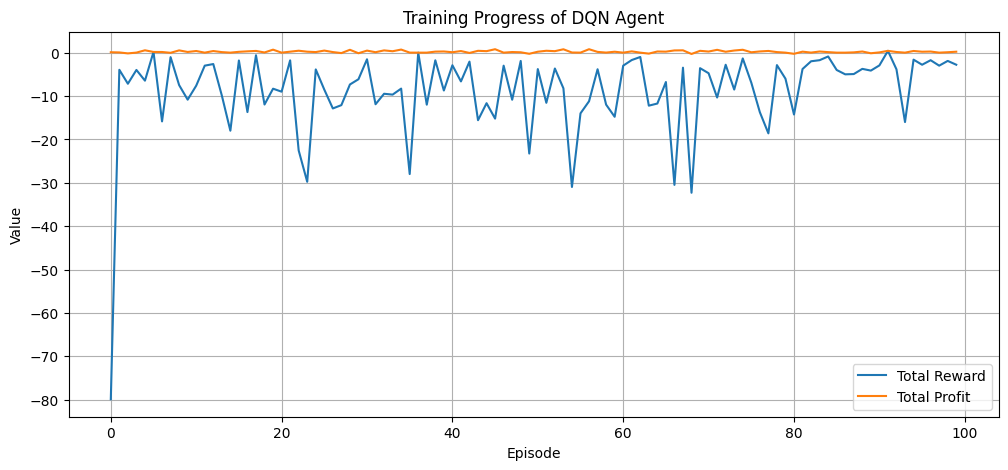

In [16]:
# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 5))
plt.plot(all_rewards, label='Total Reward')
plt.plot(all_profits, label='Total Profit')
plt.xlabel("Episode")
plt.ylabel("Value")
plt.title("Training Progress of DQN Agent")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Kelas untuk lingkungan trading DQN khusus test set menyimpan aksi dan harga
class DQNTradingEnv:
    """
    Lingkungan untuk trading menggunakan DQN (Deep Q-Network).
    Lingkungan ini menyediakan state, action, dan reward untuk agen trading.
    """
    # Fungsi inisialisasi lingkungan
    def __init__(self, data, window_size=5):
        self.data = data
        self.window_size = window_size
        self.actions = []   # ← untuk simpan (step, action, price)
        self.prices = []    # ← simpan harga Close setiap step
        self.reset()

    # Fungsi reset untuk menginisialisasi ulang lingkungan
    def reset(self):
        self.current_step = self.window_size
        self.holding = False
        self.buy_price = 0
        self.total_profit = 0
        self.done = False
        self.history = []
        self.actions = []   # ← untuk simpan (step, action, price)
        self.prices = []    # ← simpan harga Close setiap step

        return self._get_state()

    # Fungsi untuk mendapatkan state saat ini
    def _get_state(self):
        """
        Mengambil state saat ini dari data.
        State terdiri dari window data yang berisi harga Open, High, Low, Close, Volume, dan Change.
        """
        return self.data[self.current_step].flatten()

    # Fungsi untuk melakukan langkah dalam lingkungan
    def step(self, action):
        """
        Actions:
        0 = Buy
        1 = Sell
        2 = Hold
        """
        reward = 0
        # Dapatkan harga penutupan dari hari terakhir dalam window
        window = self.data[self.current_step]
        close_price = float(window[-1][3])  # Hari ke-5, kolom Close

        if action == 0:  # Buy
            if not self.holding:
                self.holding = True
                self.buy_price = close_price
            else:
                reward = -1  # penalti karena sudah beli

        elif action == 1:  # Sell
            if self.holding:
                reward = float(close_price - self.buy_price)
                # reward = close_price - self.buy_price
                self.total_profit += reward
                self.holding = False
                self.buy_price = 0
            else:
                reward = -1  # penalti karena jual tanpa beli

        elif action == 2:  # Hold
            reward = 0
        
        # Simpan harga & aksi (hanya untuk keperluan visualisasi)
        self.actions.append((self.current_step, action, close_price))
        self.prices.append(close_price)

        # Lanjut ke step berikutnya
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True

        next_state = self._get_state() if not self.done else None

        return next_state, reward, self.done

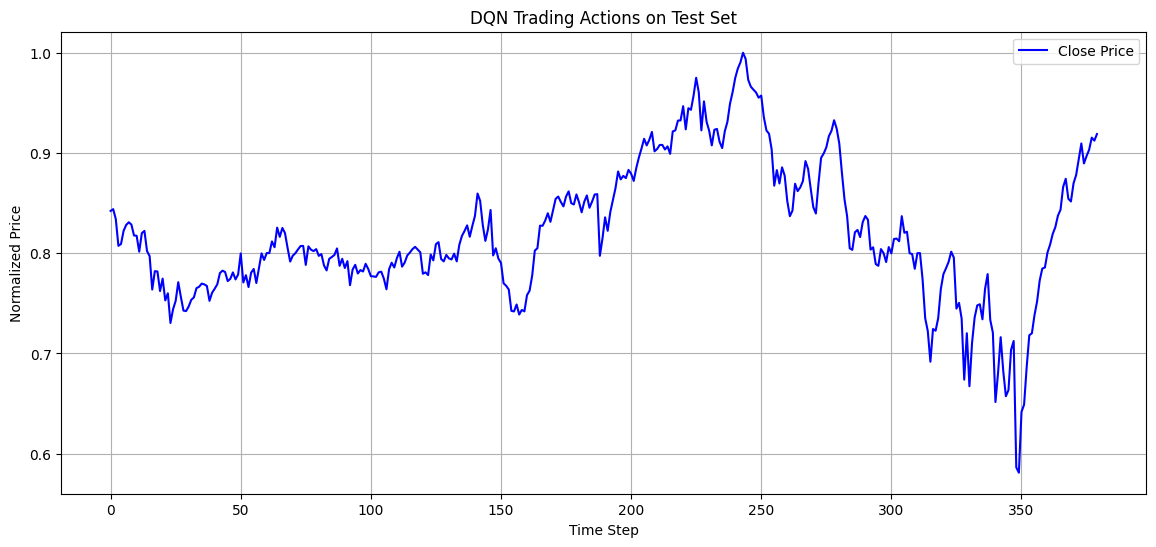

In [18]:
# Evaluasi ulang
test_env = DQNTradingEnv(X_test, window_size=5)
state = test_env.reset()
agent.epsilon = 0.0
_ = agent.act(state)  # optional dummy start

while True:
    action = agent.act(state)
    next_state, reward, done = test_env.step(action)
    state = next_state
    if done:
        break

# Ambil data dari environment
prices = test_env.prices
actions = test_env.actions

# Siapkan data titik Buy & Sell
buy_points = [(step, price) for step, action, price in actions if action == 0]
sell_points = [(step, price) for step, action, price in actions if action == 1]

# Plot harga
plt.figure(figsize=(14, 6))
plt.plot(prices, label='Close Price', color='blue')

# Tambahkan titik Buy (▲ hijau) dan Sell (▼ merah)
if buy_points:
    buy_steps, buy_prices = zip(*buy_points)
    plt.scatter(buy_steps, buy_prices, marker='^', color='green', label='Buy')
if sell_points:
    sell_steps, sell_prices = zip(*sell_points)
    plt.scatter(sell_steps, sell_prices, marker='v', color='red', label='Sell')

plt.title("DQN Trading Actions on Test Set")
plt.xlabel("Time Step")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Print total profit dari test set
print(f"Total Profit from Test Set: {test_env.total_profit:.2f}")

Total Profit from Test Set: 0.00
